# BERT 모델을 활용한 두 문장 관계 분류 학습

> 작성자      
```
* 김성현 (bananaband657@gmail.com)  
김바다 (qkek983@gmail.com)
박상희 (parksanghee0103@gmail.com)  
이정우 (jungwoo.l2.rs@gmail.com)
```
[CC BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/2.0/kr/)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [3]:
import torch
import sys

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
data = open(f'./drive/MyDrive/Colab Notebooks/para_kqc_sim_data.txt', 'r', encoding='utf-8')
lines = data.readlines()

# 데이터셋 구조 확인
print(lines[0:10])

['메일을 다 비울까 아니면 안읽은 것만 지울까?\t메일 중에 안읽은 것만 지울까? 다 지울까?\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t안읽은 메일만 지워 다지워?\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t다 지울까 안읽은 메일만 지울까?\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t전체를 비울까 안읽은 것만 비울까?\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t안읽은 메일만 지울꺼야? 아니면 다 지울꺼야?\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t어떻게 지울까? 안읽은거만? 전체 다?\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t메일을 다 지울지 안읽은거만 지울지 알려주세요\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t메일은 다 지울수도 있고, 안읽은거만 지울 수도 있어. 어떻게 할래?\t1\n', '메일을 다 비울까 아니면 안읽은 것만 지울까?\t안읽은 메일만 지우든가, 다 지울 수 있는데 어떻게 할꺼야?\t1\n', '지메일 쓸래, 네이버 메일 쓸래\t지메일을 쓸거야 네이버 메일을 쓸꺼야?\t1\n']


In [6]:
import random
random.shuffle(lines)

In [7]:
train = {'sent_a':[], 'sent_b':[], 'label':[]}
test = {'sent_a':[], 'sent_b':[], 'label':[]}
for i, line in enumerate(lines):
    if i < len(lines) * 0.8:
        line = line.strip()
        train['sent_a'].append(line.split('\t')[0])
        train['sent_b'].append(line.split('\t')[1])
        train['label'].append(int(line.split('\t')[2]))
    else:
        line = line.strip()
        test['sent_a'].append(line.split('\t')[0])
        test['sent_b'].append(line.split('\t')[1])
        test['label'].append(int(line.split('\t')[2]))

In [8]:
import pandas as pd

In [9]:
train_data = pd.DataFrame({"sent_a":train['sent_a'], "sent_b":train['sent_b'], "label":train['label']})
test_data = pd.DataFrame({"sent_a":test['sent_a'], "sent_b":test['sent_b'], "label":test['label']})

In [10]:
# 데이터 중복을 제외한 갯수 확인
print("학습데이터 : ",train_data.groupby(['sent_a', 'sent_b']).ngroups," 라밸 : ",train_data['label'].nunique())
print("데스트 데이터 : ",test_data.groupby(['sent_a', 'sent_b']).ngroups," 라벨 : ",test_data['label'].nunique())

# 중복 데이터 제거
train_data.drop_duplicates(subset=['sent_a', 'sent_b'], inplace= True)
test_data.drop_duplicates(subset=['sent_a', 'sent_b'], inplace= True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

학습데이터 :  15184  라밸 :  2
데스트 데이터 :  3796  라벨 :  2
중복 제거 후 학습 데이터셋 : 15184
중복 제거 후 테스트 데이터셋 : 3796


In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# null 데이터 제거
train_data.replace('', np.nan, inplace=True)
test_data.replace('', np.nan, inplace=True)

train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('null 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('null 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

null 제거 후 학습 데이터셋 : 15184
null 제거 후 테스트 데이터셋 : 3796


In [13]:
print(train_data['sent_a'][0])
print(train_data['sent_b'][0])
print(train_data['label'][0])

트위치 계정에 메일을 몇개 등록할 수 있니?
받은 메일함에 최대 몇 통의 메일을 저장할 수 있나요?
0


학습 전제 문장의 최대 길이 : 49
전제 문장의 평균 길이 : 22.362881981032665


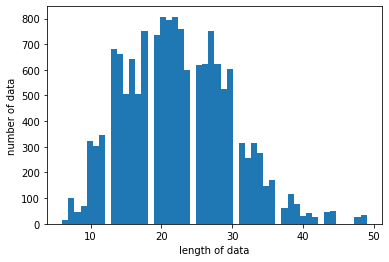

학습 가정 문장의 최대 길이 : 65
가정 문장의 평균 길이 : 25.573761854583772


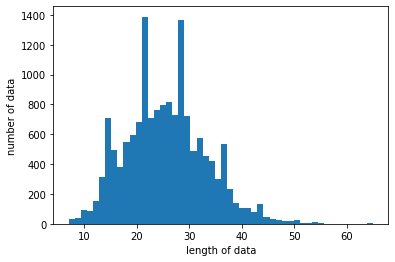

In [14]:
# 학습 전제 문장 길이조사
print('학습 전제 문장의 최대 길이 :',max(len(l) for l in train_data['sent_a']))
print('전제 문장의 평균 길이 :',sum(map(len, train_data['sent_a']))/len(train_data['sent_a']))

plt.hist([len(s) for s in train_data['sent_a']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

# 학습 가정 문장 길이조사
print('학습 가정 문장의 최대 길이 :',max(len(l) for l in train_data['sent_b']))
print('가정 문장의 평균 길이 :',sum(map(len, train_data['sent_b']))/len(train_data['sent_b']))

plt.hist([len(s) for s in train_data['sent_b']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [15]:
# Store the model we want to use
from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [16]:
tokenized_train_sentences = tokenizer(
    list(train_data['sent_a'][0:]),
    list(train_data['sent_b'][0:]),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    max_length=64
    )

In [17]:
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=64, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '트', '##위', '##치', '계', '##정에', '메', '##일', '##을', '몇', '##개', '등', '##록', '##할', '수', '있', '##니', '?', '[SEP]', '받은', '메', '##일', '##함', '##에', '최대', '몇', '통', '##의', '메', '##일', '##을', '저', '##장', '##할', '수', '있', '##나', '##요', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[101, 9890, 19855, 18622, 8887, 77763, 9272, 18392, 10622, 9282, 21789, 9121, 31398, 14843, 9460, 9647, 25503, 136, 102, 74141, 9272, 18392, 48533, 10530, 99405, 9282, 9879, 10459, 9272, 18392, 10622, 9663, 13890, 14843, 9460, 9647, 16439, 48549, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [18]:
tokenized_test_sentences = tokenizer(
    list(test_data['sent_a'][0:]),
    list(test_data['sent_b'][0:]),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    max_length=64
    )

In [19]:
train_label = train_data['label'].values[0:]
test_label = test_data['label'].values[0:]

In [20]:
print(train_label[0])

0


In [21]:
class MultiSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [22]:
train_dataset = MultiSentDataset(tokenized_train_sentences, train_label)
test_dataset = MultiSentDataset(tokenized_test_sentences, test_label)

In [23]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments,  BertConfig

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,
    save_total_limit=2,
    metric_for_best_model='accuracy',
    evaluation_strategy='steps',
    eval_steps=500,
)

In [24]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) 
model.parameters
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [25]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [26]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

In [27]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.326500
1000,0.282300
1500,0.244500
2000,0.190400
2500,0.163300
3000,0.151000
3500,0.111300
4000,0.097500
4500,0.077200
5000,0.059000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.

TrainOutput(global_step=5694, training_loss=0.15614648664211198, metrics={'train_runtime': 1954.2693, 'train_samples_per_second': 2.914, 'total_flos': 3111033583816704.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 8192, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -744865792, 'train_mem_gpu_alloc_delta': 2144760320, 'train_mem_cpu_peaked_delta': 758116352, 'train_mem_gpu_peaked_delta': 427753984})

In [28]:
trainer.evaluate(eval_dataset=test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'epoch': 3.0,
 'eval_accuracy': 0.981822971548999,
 'eval_f1': 0.9810595662915179,
 'eval_loss': 0.10425252467393875,
 'eval_mem_cpu_alloc_delta': 1851392,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 138603520,
 'eval_precision': 0.9781061850027367,
 'eval_recall': 0.9840308370044053,
 'eval_runtime': 27.0119,
 'eval_samples_per_second': 140.531}

In [ ]:
trainer.save_model('./results')

In [ ]:
# native training using torch

# bert_config = BertConfig.from_pretrained(MODEL_NAME)
# bert_config.num_labels = 3
# model = BertForSequenceClassification(bert_config) 
# model.to(device)
# model.train()

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# optim = AdamW(model.parameters(), lr=5e-5)

# for epoch in range(3):
#     for batch in train_loader:
#         optim.zero_grad()
#         input_ids = batch['input_ids'].to(device)
#         attention_mask = batch['attention_mask'].to(device)
#         labels = batch['labels'].to(device)
#         outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs[0]
#         loss.backward()
#         optim.step()

In [29]:
# predict함수
# 0: "non_similar", 1: "similar"
def sentences_predict(sent_A, sent_B):
    model.eval()
    tokenized_sent = tokenizer(
            sent_A,
            sent_B,
            return_tensors="pt",
            truncation=True,
            add_special_tokens=True,
            max_length=64
    )
    
    tokenized_sent.to('cuda:0')
    with torch.no_grad():# 그라디엔트 계산 비활성화
        outputs = model(
            input_ids=tokenized_sent['input_ids'],
            attention_mask=tokenized_sent['attention_mask'],
            token_type_ids=tokenized_sent['token_type_ids']
            )

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits)

    if result == 0:
      result = 'non_similar'
    elif result == 1:
      result = 'similar'
    return result

In [30]:
print(sentences_predict('오늘 날씨가 어때요?','오늘의 날씨를 알려줘')) # similar
print(sentences_predict('오늘 날씨가 어때요?','기분 진짜 안좋다.')) # non_similar
print(sentences_predict('오늘 날씨가 어때요?','오늘 기분 어떠세요?')) # non_similar
print(sentences_predict('오늘 날씨가 어때요?','오늘 기분이 어때요?')) # non_similar
print(sentences_predict('오늘 날씨가 어때요?','지금 날씨가 어때요?')) # non_similar
print(sentences_predict('무협 소설 추천해주세요.','무협 장르의 소설 추천 부탁드립니다.')) # similar
print(sentences_predict('무협 소설 추천해주세요.','판타지 소설 추천해주세요.')) # non_similar
print(sentences_predict('무협 소설 추천해주세요.','무협 느낌나는 소설 하나 추천해주실 수 있으실까요?')) # similar

similar
non_similar
non_similar
non_similar
similar
similar
non_similar
similar
